In [1]:
# Checking the device GPU for the faster computation
import torch

has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")


MPS (Apple Metal) is AVAILABLE
Target device is mps


In [40]:
# Importing the necessary datasets
from torchvision import datasets
from torchvision.transforms import ToTensor

In [41]:
# Splitting the dataset into the training and testing data
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

In [42]:
# Checking the datasets
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [43]:
# Visualizing the dataset
train_data.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [44]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [45]:
train_data.targets.shape

torch.Size([60000])

In [46]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [47]:
# Importing the training data and testing data to the DATALOADERS for further computation

from torch.utils.data import DataLoader

loaders = {
    'train' : DataLoader(
        train_data,
        batch_size = 100,
        shuffle = True,
        num_workers = 1
    ),
    
    'test' : DataLoader(
        test_data,
        batch_size = 100,
        shuffle = True,
        num_workers = 1
    )
}

In [48]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1753a32e0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1753a3e50>}

In [49]:
# Importing necessary libraires for designing the network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Designing the Convolutional Neural Network class
class CNN(nn.Module):

    # Initializing the different layers of the desired CNN network
    def __init__(self):
        super(CNN,self).__init__()
        
        self.conv1 = nn.Conv2d(1,10,kernel_size=5)
        self.conv2 = nn.Conv2d(10,20,kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50,10)
        

    # Defining the activation, dropout and the falttening function
    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x = x.view(-1,320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        x = F.relu(self.fc2(x))
        
        return F.softmax(x)
    


In [50]:
import torch

# Transfering the model to the GPU acceleration
device = "mps" if torch.backends.mps.is_built() else "cuda" if torch.cuda.is_available() else "cpu"

model = CNN().to(device)

# Defining the optimizer for the network
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Defining the loss function
loss_fn = nn.CrossEntropyLoss()

# Defining the trianing using th train dataloader
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(f'Tain Epoch: {epoch} [{batch_idx*len(data)}/{len(loaders["train"].dataset)} ({100. * batch_idx / len(loaders["train"]):,.2f}%)]\t{loss.item():,.6f}')
            


# Defining the testing dataloader for the testing process
def test():
    # This phase actually evaluates the trianing model
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output,target).item()
            pred = output.argmax(dim=1,keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            

    # Claculates the test loss
    test_loss /=len(loaders['test'].dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders["test"].dataset)} ({100. * correct/len(loaders["test"].dataset):.2f}%\n)')

In [51]:
# Checking the device on which the model is running for GPU acceleration
device

'mps'

In [52]:
# Now training and testing phases begins
for epoch in range(1,11):
    train(epoch)
    test()

/var/folders/pp/6hd8jk1556g6l4zq6wkhvsgr0000gn/T/ipykernel_39644/3585594267.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Tain Epoch: 1 [0/60000 (0.00%)]	2.302361
Tain Epoch: 1 [2000/60000 (3.33%)]	2.296860
Tain Epoch: 1 [4000/60000 (6.67%)]	2.199740
Tain Epoch: 1 [6000/60000 (10.00%)]	2.083681
Tain Epoch: 1 [8000/60000 (13.33%)]	2.016994
Tain Epoch: 1 [10000/60000 (16.67%)]	1.779091
Tain Epoch: 1 [12000/60000 (20.00%)]	1.807790
Tain Epoch: 1 [14000/60000 (23.33%)]	1.791471
Tain Epoch: 1 [16000/60000 (26.67%)]	1.787055
Tain Epoch: 1 [18000/60000 (30.00%)]	1.797664
Tain Epoch: 1 [20000/60000 (33.33%)]	1.818819
Tain Epoch: 1 [22000/60000 (36.67%)]	1.684548
Tain Epoch: 1 [24000/60000 (40.00%)]	1.753721
Tain Epoch: 1 [26000/60000 (43.33%)]	1.708310
Tain Epoch: 1 [28000/60000 (46.67%)]	1.727543
Tain Epoch: 1 [30000/60000 (50.00%)]	1.665179
Tain Epoch: 1 [32000/60000 (53.33%)]	1.705520
Tain Epoch: 1 [34000/60000 (56.67%)]	1.648959
Tain Epoch: 1 [36000/60000 (60.00%)]	1.715382
Tain Epoch: 1 [38000/60000 (63.33%)]	1.690958
Tain Epoch: 1 [40000/60000 (66.67%)]	1.625208
Tain Epoch: 1 [42000/60000 (70.00%)]	1.717591

In [53]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Define a function to compute the confusion matrix
def compute_confusion_matrix(model, dataloader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    return confusion_matrix(all_targets, all_preds)

# Compute confusion matrix for test data
conf_matrix = compute_confusion_matrix(model, loaders['test'])

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


/var/folders/pp/6hd8jk1556g6l4zq6wkhvsgr0000gn/T/ipykernel_39644/3585594267.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Confusion Matrix:
[[ 972    0    0    0    0    0    4    1    3    0]
 [   0 1123    5    1    0    0    4    0    2    0]
 [   2    2 1002    5    2    0    0   11    8    0]
 [   1    0    5  986    0    6    0    7    3    2]
 [   0    1    3    0  960    0    7    0    2    9]
 [   2    0    0   15    0  868    3    1    1    2]
 [   7    3    0    0    1    2  944    0    1    0]
 [   1    4   19    4    1    0    0  992    1    6]
 [   4    5    2    1    5    3    2    4  941    7]
 [   4    5    0    5   13    5    2   10    3  962]]


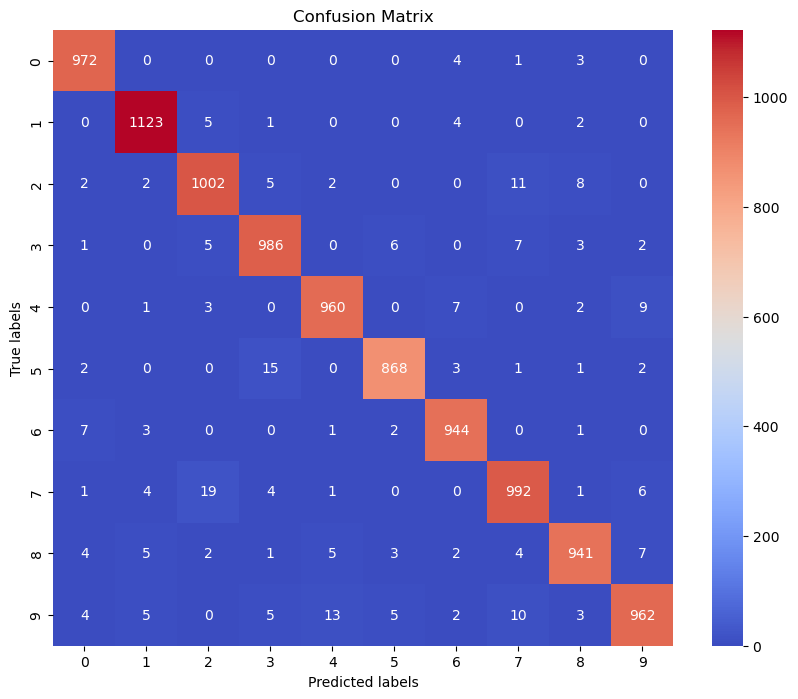

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

/var/folders/pp/6hd8jk1556g6l4zq6wkhvsgr0000gn/T/ipykernel_39644/3585594267.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch: 1, Train Loss: 1.5303, Train Acc: 93.19%, Test Loss: 1.4903, Test Acc: 97.04%
Epoch: 2, Train Loss: 1.5294, Train Acc: 93.28%, Test Loss: 1.4891, Test Acc: 97.19%
Epoch: 3, Train Loss: 1.5270, Train Acc: 93.50%, Test Loss: 1.4875, Test Acc: 97.34%
Epoch: 4, Train Loss: 1.5257, Train Acc: 93.62%, Test Loss: 1.4861, Test Acc: 97.49%
Epoch: 5, Train Loss: 1.5224, Train Acc: 93.97%, Test Loss: 1.4864, Test Acc: 97.47%
Epoch: 6, Train Loss: 1.5248, Train Acc: 93.69%, Test Loss: 1.4865, Test Acc: 97.46%
Epoch: 7, Train Loss: 1.5204, Train Acc: 94.17%, Test Loss: 1.4850, Test Acc: 97.59%
Epoch: 8, Train Loss: 1.5198, Train Acc: 94.18%, Test Loss: 1.4835, Test Acc: 97.77%
Epoch: 9, Train Loss: 1.5190, Train Acc: 94.27%, Test Loss: 1.4837, Test Acc: 97.76%
Epoch: 10, Train Loss: 1.5170, Train Acc: 94.46%, Test Loss: 1.4833, Test Acc: 97.83%


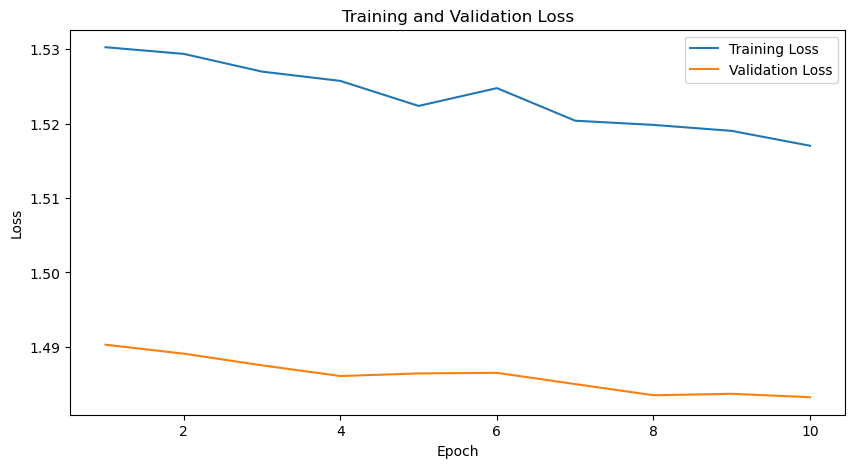

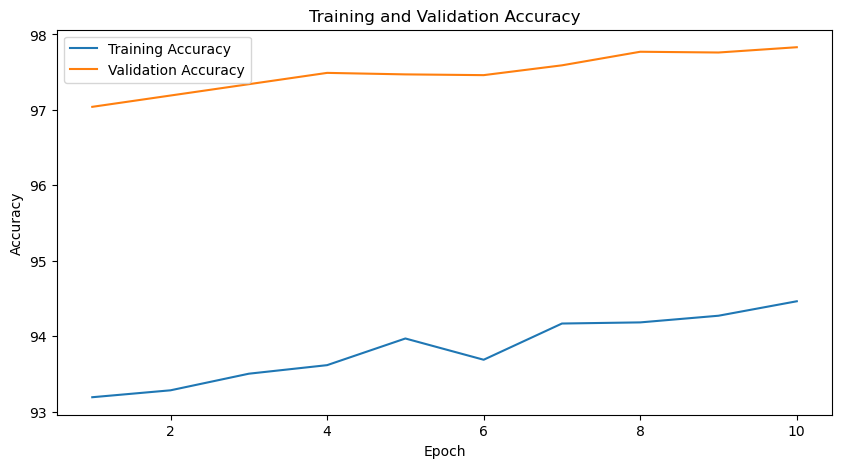

In [38]:
# This code actually stores the 

import matplotlib.pyplot as plt

# Lists to store training and validation loss values
train_losses = []
test_losses = []

# Lists to store training and validation accuracy values
train_accuracies = []
test_accuracies = []

# Function to train the model and compute metrics
def train_and_evaluate(epoch):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = output.max(1)
        total_train += target.size(0)
        correct_train += predicted.eq(target).sum().item()
    train_losses.append(train_loss / len(loaders['train']))
    train_accuracy = 100. * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_fn(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)
            total_test += target.size(0)
            correct_test += predicted.eq(target).sum().item()
    test_losses.append(test_loss / len(loaders['test']))
    test_accuracy = 100. * correct_test / total_test
    test_accuracies.append(test_accuracy)
    
    print(f'Epoch: {epoch}, Train Loss: {train_loss / len(loaders["train"]):.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss / len(loaders["test"]):.4f}, Test Acc: {test_accuracy:.2f}%')

# Train the model
for epoch in range(1, 11):
    train_and_evaluate(epoch)

# Plotting loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), train_losses, label='Training Loss')
plt.plot(range(1, 11), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), train_accuracies, label='Training Accuracy')
plt.plot(range(1, 11), test_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
